In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Import & Visualize

In [2]:
X_train = pd.read_csv('/Users/savage/Kaggle/robots/input/X_train.csv')
y_train = pd.read_csv('/Users/savage/Kaggle/robots/input/y_train.csv')
X_test = pd.read_csv('/Users/savage/Kaggle/robots/input/X_test.csv')

In [3]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)

X_train:  (487680, 13)
y_train:  (3810, 3)
X_test:  (488448, 13)


In [4]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [5]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [6]:
print(X_train.isnull().sum().sum())
print(y_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

0
0
0


In [7]:
X_train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [8]:
y_train.describe()

,series_id,group_id
count,3810.000000,3810.000000
mean,1904.500000,37.601312
std,1099.996591,20.982743
min,0.000000,0.000000
25%,952.250000,19.000000
50%,1904.500000,39.000000
75%,2856.750000,55.000000
max,3809.000000,72.000000


Text(0,0.5,'counts')

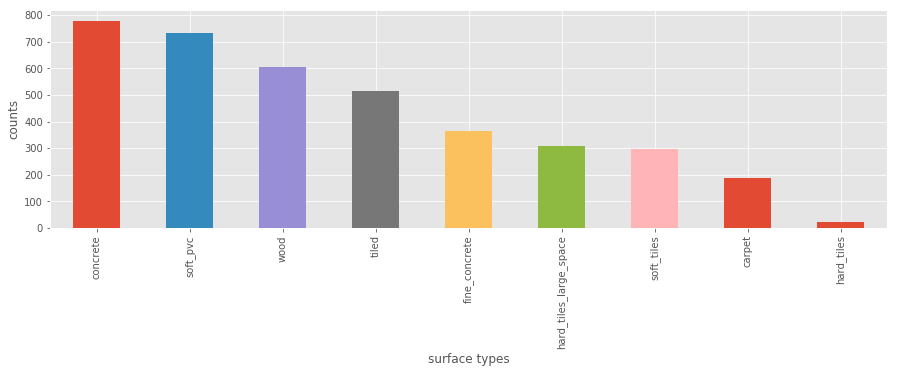

In [9]:
fig = plt.figure(figsize=(15, 4))
y_train['surface'].value_counts().plot(kind='bar')
plt.xlabel('surface types')
plt.ylabel('counts')

## Feature Engineering

In [10]:
def quaternion2euler(x, y, z, w):
    import math
    t0 = 2.0 * (w*x + y*z)
    t1 = 1.0 - 2.0 * (x*x + y*y)
    X = math.atan2(t0, t1)
    
    t2 = 2.0 * (w*y - z*x)
    if t2 > 1.0:
        t2 = 1.0
    elif t2 < -1.0:
        t2 = -1.0
    Y = math.asin(t2)
    
    t3 = 2.0 * (w*z + x*y)
    t4 = 1.0 - 2.0 * (y*y + z*z)
    Z = math.atan2(t3, t4)
    
    return X, Y, Z

In [11]:
def f1(x):
    return np.mean(np.diff(np.abs(np.diff(x))))
    
def f2(x):
    return np.mean(np.abs(np.diff(x)))

In [12]:
def feature_engineering(df):
    new = pd.DataFrame()
    df['total_angular_velocity'] = (df['angular_velocity_X'] ** 2 +
                                     df['angular_velocity_Y'] ** 2 +
                                     df['angular_velocity_Z'] ** 2) ** 0.5
    df['total_linear_acceleration'] = (df['linear_acceleration_X'] ** 2 +
                                     df['linear_acceleration_Y'] ** 2 +
                                     df['linear_acceleration_Z'] ** 2) ** 0.5
    df['la_av_rate'] = df['total_linear_acceleration'] / df['total_angular_velocity']
    
    x = df['orientation_X'].tolist()
    y = df['orientation_Y'].tolist()
    z = df['orientation_Z'].tolist()
    w = df['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion2euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    df['euler_x'], df['euler_y'], df['euler_z'] = nx, ny, nz
    df['total_angle'] = (df['euler_x'] ** 2 +
                            df['euler_y'] ** 2 +
                            df['euler_z'] ** 2) ** 0.5
    df['ang_la_rate'] = df['total_angle'] / df['total_linear_acceleration']
    df['ang_av_rate'] = df['total_angle'] / df['total_angular_velocity']
    
    for col in df.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        new[col + '_median'] = df.groupby(['series_id'])[col].median()
        new[col + '_min'] = df.groupby(['series_id'])[col].min()
        new[col + '_max'] = df.groupby(['series_id'])[col].max()
        new[col + '_std'] = df.groupby(['series_id'])[col].std()
        new[col + '_range'] = new[col + '_max'] - new[col + '_min']
        new[col + '_max_min_rate'] = new[col + '_max'] / new[col + '_min']
        
        new[col + '_mean_abs_change'] = df.groupby(['series_id'])[col].apply(f2)
        new[col + '_mean_change_of_abs_change'] = df.groupby(['series_id'])[col].apply(f1)
        new[col + '_abs_max'] = df.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = df.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        new[col + '_abs_avg'] = (new[col + '_abs_max'] + new[col + '_abs_min']) / 2
        
    return new

In [13]:
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

In [14]:
X_train.head()

,orientation_X_mean,orientation_X_median,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_range,orientation_X_max_min_rate,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,...,ang_av_rate_min,ang_av_rate_max,ang_av_rate_std,ang_av_rate_range,ang_av_rate_max_min_rate,ang_av_rate_mean_abs_change,ang_av_rate_mean_change_of_abs_change,ang_av_rate_abs_max,ang_av_rate_abs_min,ang_av_rate_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.758530,-0.75953,-0.75822,0.000363,0.00131,0.998275,0.000015,2.380952e-07,0.75953,...,19.504720,298.761364,44.060971,279.256644,15.317388,37.481365,0.280575,298.761364,19.504720,159.133042
1,-0.958606,-0.958595,-0.95896,-0.95837,0.000151,0.00059,0.999385,0.000023,-4.761905e-07,0.95896,...,10.012514,142.881670,21.735220,132.869156,14.270310,14.932243,0.040438,142.881670,10.012514,76.447092
2,-0.512057,-0.512035,-0.51434,-0.50944,0.001377,0.00490,0.990473,0.000041,0.000000e+00,0.51434,...,20.553513,355.472539,47.187945,334.919026,17.294977,29.160415,-0.111356,355.472539,20.553513,188.013026
3,-0.939169,-0.939170,-0.93968,-0.93884,0.000227,0.00084,0.999106,0.000026,-6.349206e-07,0.93968,...,5.580044,202.142335,30.470678,196.562291,36.225941,19.603943,1.127525,202.142335,5.580044,103.861189
4,-0.891301,-0.890940,-0.89689,-0.88673,0.002955,0.01016,0.988672,0.000080,7.936508e-08,0.89689,...,12.840288,32.676098,4.770065,19.835810,2.544810,1.225844,-0.003453,32.676098,12.840288,22.758193


In [15]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)

X_train:  (3810, 228)
y_train:  (3810, 3)
X_test:  (3816, 228)


## Model

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])

In [17]:
X_train.fillna(0, inplace = True)
X_train.replace(-np.inf, 0, inplace = True)
X_train.replace(np.inf, 0, inplace = True)
X_test.fillna(0, inplace = True)
X_test.replace(-np.inf, 0, inplace = True)
X_test.replace(np.inf, 0, inplace = True)

In [18]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [19]:
rf_clf = RandomForestClassifier(n_estimators=1200, n_jobs = -1)
rf_clf.fit(X_train, y_train['surface'])
print(cross_val_score(rf_clf, X_train,  y_train['surface'], cv=5))

[0.82245431 0.87058824 0.90288714 0.88684211 0.8996037 ]


In [20]:
'''param_1 = {'n_estimators': list(range(300, 1001, 100))}
gsearch_1 = GridSearchCV(estimator=RandomForestClassifier(),
                        param_grid = param_1, cv=5)
gsearch_1.fit(X_train, y_train['surface'])
gsearch_1.grid_scores_, gsearch_1.best_params_, gsearch_1.best_score_
'''

"param_1 = {'n_estimators': list(range(300, 1001, 100))}\ngsearch_1 = GridSearchCV(estimator=RandomForestClassifier(),\n                        param_grid = param_1, cv=5)\ngsearch_1.fit(X_train, y_train['surface'])\ngsearch_1.grid_scores_, gsearch_1.best_params_, gsearch_1.best_score_\n"

In [21]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, 
                       train_sizes=np.linspace(0.05, 1., 20), verbose=0, plot=True):
    from sklearn.model_selection import learning_curve
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Numbers of samples')
    plt.ylabel('Score')
    plt.gca().invert_yaxis()
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color='b')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color='r')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='b', label='Train Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r', label='Test Score')
    plt.legend(loc='best')
    plt.draw()
    plt.gca().invert_yaxis()
    plt.show()

In [22]:
#plot_learning_curve(rf_clf, 'RF Learning Curve', X_train, y_train['surface'])

In [23]:
'''
from sklearn.ensemble import BaggingClassifier
bag_xgb = BaggingClassifier(xgb_clf, n_estimators=20, n_jobs=-1, max_samples=0.8,
                          max_features=1.0, bootstrap=True, bootstrap_features=False)
bag_xgb.fit(X_train, y_train['surface'])
print(cross_val_score(bag_xgb, X_train,  y_train['surface'], cv=5))
'''

"\nfrom sklearn.ensemble import BaggingClassifier\nbag_xgb = BaggingClassifier(xgb_clf, n_estimators=20, n_jobs=-1, max_samples=0.8,\n                          max_features=1.0, bootstrap=True, bootstrap_features=False)\nbag_xgb.fit(X_train, y_train['surface'])\nprint(cross_val_score(bag_xgb, X_train,  y_train['surface'], cv=5))\n"

In [24]:
predictions = rf_clf.predict(X_test)
submission = le.inverse_transform(predictions)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [25]:
ans = pd.DataFrame({'series_id': [i for i in range(0, 3816)],
                    'surface': submission})
ans.to_csv('/Users/savage/Kaggle/robots/ans/rf_1200.csv', index=False)